In [117]:
config = {
    'seed': 507,
    #'valid_ratio': 0.20,
    #'test_ratio': 0.1,
    'num_epochs': 200,
    'batch_size': 1,
    'learning_rate': 1e-4, #2e-4
    'weight_decay':0.00002, #0.00001
    'early_stop': 20,
    'save_path': './model_weights/LSTM/LSTM.ckpt',
    'input_size': 18,
    'prev_step_range' : 60, #52:一年預測下一年 #365:現在改一年
    'target_window_size' : 1, #一次預測多久時間，
    'test_year': 2021, #哪一年要被測試
    'model_name': "LSTM_1208",
    'time_range': 365 #用一天為尺度就是365, 週為52
}

# 過程

## 套件安裝

In [118]:
# # 測試使用 Scaler 對預測結果進行逆轉換(先製造假矩陣符合scaler後轉回來)
# testing = test_df.iloc[:, 0].to_numpy()
# testing_reshaped = np.zeros((testing.shape[0], config['input_size']))
# testing_reshaped[:, 0] = testing #testing[:, 0]
# inverse_transformed_value = scaler.inverse_transform(testing_reshaped)[:, 0]
# inverse_transformed_value

In [119]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/統計深度學習') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['雨量',
 '雛雞',
 '雞隻',
 '鴨蛋價格',
 '進口飼料',
 '雞蛋價格',
 'concat-data',
 '氣溫',
 'concatData.ipynb',
 'LSTM-滾動-4週window.ipynb',
 'model_weights',
 'LSTM-直接預測全部1207.ipynb']

In [120]:
# always needed
import math, os, random, csv
import pandas as pd
import numpy as np

# log and save
import json, logging, pickle, sys, shutil, copy
# torch
import torch
import torch.nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU
import torchvision
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics

# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Using device: cuda


## 模型
https://discuss.pytorch.org/t/understanding-lstm-input/31110/5 LSTM input

In [121]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        self.input_size = config['input_size']
        self.seq_len = config['prev_step_range'] #kktv內259天，在這份資料集 滾動為4週預測一週=4
        self.n_layers = 2 # LSTM的层数
        self.hidden_dim = 128 # 隐状态的维度，即LSTM输出的隐状态的维度
        self.output_size = config['target_window_size'] #輸出為一年蛋價格!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        self.lstm = nn.LSTM(input_size = self.input_size, # 输入的维度
                            hidden_size = self.hidden_dim, # LSTM输出的hidden_state的维度
                            num_layers = self.n_layers, # LSTM的层数
                            dropout= 0.4,
                            batch_first=True # 第一个维度是否是batch_size
                           )
        self.fc_1 = nn.Linear(self.hidden_dim, 64) #fc1
        self.fc_2 =  nn.Linear(64, self.output_size) #fc2
        self.sigmoid = nn.Sigmoid() # 线性层输出后，还需要过一下sigmoid
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        x: 本次的输入, 其size为(batch_size, 259, 4), 259 為sequence len, 4為input_dim
        其中h和c的size都为(n_layers, batch_size, hidden_dim), 即(2, 1, 128)
        """
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device) #非雙向
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        out, (ht,ct) = self.lstm(x, (h_0,c_0)) #out 為 (batch_size64, seqlen37, hidden_dim128)
        out = out[:, -1, :]
        out = out.reshape(batch_size, -1)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out)
        return out

## 資料長相, 簡單前處理, 記得最後要把y縮放回去(scaler)

### 2018~2021訓練, 2021~2022預測
先把所有年份都抓出來前處理，切好週以後把最後52當測試，再回來52當驗證

In [122]:
folder_path = './concat-data/臺中/'
dfs = []
for year in range(2018, config['test_year']+1):
    file_path = os.path.join(folder_path, f'{year}.csv')
    df = pd.read_csv(file_path)
    dfs.append(df)
all_df = pd.concat(dfs, ignore_index=True)
all_df['Precipitation'] = pd.to_numeric(all_df['Precipitation'], errors='coerce').fillna(0).astype(int) #Preceipitation轉成0
all_df['ImportChickenQuantity'].fillna(0, inplace=True) #沒進口時等於零
all_df.drop(['StationName'], axis=1, inplace=True) #打掉縣市名稱
print("合併後的df:", all_df.shape)
#train_df.tail()

合併後的df: (1461, 19)


In [123]:
all_df['Date'] = pd.to_datetime(all_df['Date'])
all_df.set_index('Date', inplace=True)
all_df = all_df.apply(pd.to_numeric, errors='coerce') #字串全轉數字
#all_df = all_df.resample('W').mean()

In [124]:
print(all_df.shape)
all_df.tail()

(1461, 18)


,egg_TaijinPrice,Duckegg_TNN_TaijinPrice,入中雞雛數,產蛋隻數,均 日 產蛋箱數,淘汰隻數,目 前 換羽隻數,WhiteChickQuantity,RedChickQuantity,ImportChickenQuantity,玉米粒,黃豆粉,玉米粉,脫殼豆粉,高蛋白豆粉,AirTemperatureMean,AirTemperatureMax,Precipitation
Date,,,,,,,,,,,,,,,,,,
2021-12-27,34.5,38.0,1508459.0,33574033.0,122899.0,1211918.0,715929.0,382887,52913,0.0,14.2,16.3,14.45,20.9,17.5,18.8,28.2,1
2021-12-28,34.5,38.0,1508459.0,33574033.0,122899.0,1211918.0,715929.0,382887,52913,0.0,14.3,16.5,14.55,20.9,17.7,18.8,28.2,0
2021-12-29,34.5,38.0,1508459.0,33574033.0,122899.0,1211918.0,715929.0,382887,52913,0.0,14.5,16.7,14.65,20.9,17.9,18.8,28.2,0
2021-12-30,34.5,38.0,1508459.0,33574033.0,122899.0,1211918.0,715929.0,382887,52913,0.0,14.8,16.7,14.85,20.9,17.9,18.8,28.2,0
2021-12-31,34.5,38.0,1508459.0,33574033.0,122899.0,1211918.0,715929.0,382887,52913,0.0,14.8,16.7,14.85,20.9,17.9,18.8,28.2,0


## 補值、標準化

In [125]:
from sklearn.impute import SimpleImputer
column_names = all_df.columns #紀錄所有欄位名稱
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(all_df)

# 將填充後的數據轉換為DataFrame #這兩個dataframe是拿來產生之後預測的
all_df = pd.DataFrame(data_imputed, columns=column_names)
test_df = all_df.iloc[-(config['time_range']+config['prev_step_range']):, :] #會重疊到一部分valid
train_df = all_df.iloc[:-(config['time_range']), :]
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1096, 18)
Test set shape: (425, 18)


In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=column_names)
test_df = pd.DataFrame(scaler.transform(test_df), columns=column_names)

In [127]:
# 有209週的訓練價格資料，每週有18個特徵, 蛋價格在第一個
# 另外還有2022的 52週是我要預測的一整年份
def createMultipleTrainXY(dataset, prev_step_range, target_window_size): #創造訓練資料
    dataX = []
    dataY = []
    for i in range(0, len(dataset)-prev_step_range-target_window_size+1):
        x = dataset[i:i+prev_step_range, 0:dataset.shape[1]] #要第一個eggPrice
        y = dataset[i+prev_step_range:i+prev_step_range+target_window_size, 0]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

In [128]:
trainX, trainY = createMultipleTrainXY(train_df.to_numpy(), config['prev_step_range'], config['target_window_size'])
testX, testY = createMultipleTrainXY(test_df.to_numpy(), config['prev_step_range'], config['target_window_size'])
print("Train X shape:", trainX.shape) #205筆資料，每筆包含4週, 每段有18個特徵
print("Train Y shape:", trainY.shape)
print("Test X shape:", testX.shape)
print("Test Y shape:", testY.shape)

Train X shape: (1036, 60, 18)
Train Y shape: (1036, 1)
Test X shape: (365, 60, 18)
Test Y shape: (365, 1)


In [129]:
class MyDataset(Dataset):
    # data loading
    def __init__(self, X, y): #輸入x資料
        self.x = torch.from_numpy(X).to(torch.float32)
        self.y = torch.from_numpy(y).to(torch.float32)
        self.n_samples = self.x.shape[0] #總共多少筆資料，不管有沒有label過
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.n_samples
def inverse_scaler(y_list_twodim):
  # print(f"Inversing scaler...")
  # 使用 Scaler 對預測結果進行逆轉換(先製造假矩陣符合scaler後轉回來)
  results = []
  for sublist in y_list_twodim:
    sublist = sublist.cpu().numpy().reshape(-1)
    to_be_reshaped = np.zeros((sublist.shape[0], config['input_size']))
    to_be_reshaped[:, 0] = sublist
    result = scaler.inverse_transform(to_be_reshaped)[:, 0]
    results.append(result)
  results = [item for sublist in results for item in sublist]
  return results
def calculate_rmse_check(outputs, targets):
  # for i, tensor in enumerate(outputs):
  #   print(f"Shape of tensor {i + 1}: {tensor.size()}")
  # print(f"outputs shape: ({len(outputs)}, {len(outputs[0])})")
  outputs, targets = inverse_scaler(outputs), inverse_scaler(targets)
  nan_indices_outputs = [i for i, value in enumerate(outputs) if math.isnan(value)]
  havenan = 0
  for i in nan_indices_outputs:
      outputs[i] = 0  # Replace NaN with 0, for example
      havenan = 1
  if havenan:
    print("ahh there is a nan...")
  rmse = math.sqrt(mean_squared_error(outputs, targets))
  return rmse, outputs, targets
def train(model, criterion, optimizer, model_name):
  # 拿來最後畫圖
  train_rmse_list = []
  valid_rmse_list = []
  best_epoch_count = 0 #最好的model出現在哪個epoch?
  best_rmse = math.inf;
  for epoch in range(config['num_epochs']):
      check_train_outputs = []
      check_train_targets = []
      check_valid_outputs = []
      check_valid_targets = []
      model.train()
      train_pbar = tqdm(train_loader, position=0, leave=True)
      for Xs, Ys in train_pbar:
          Xs, Ys = Xs.to(device), Ys.to(device)
          optimizer.zero_grad()
          outputs = model(Xs)
          check_train_outputs.append(outputs.detach())
          check_train_targets.append(Ys.detach())
          loss = criterion(outputs, Ys)#Ys.view(-1,1)
          loss.backward()
          optimizer.step()
      model.eval()
      with torch.no_grad():
          for Xs_valid, Ys_valid in valid_loader:
                Xs_valid, Ys_valid = Xs_valid.to(device), Ys_valid.to(device)
                valid_outputs = model(Xs_valid)
                check_valid_outputs.append(valid_outputs.detach())
                check_valid_targets.append(Ys_valid.detach())
          train_rmse, _ , _ = calculate_rmse_check(check_train_outputs, check_train_targets)
          valid_rmse, _ , _ = calculate_rmse_check(check_valid_outputs, check_valid_targets)
          train_rmse_list.append(train_rmse)
          valid_rmse_list.append(valid_rmse)
          if epoch % 5 == 0:
              print(f'train rmse: {train_rmse} / valid rmse: {valid_rmse}')
          if valid_rmse < best_rmse:
              best_rmse = valid_rmse
              best_epoch_count = epoch
              torch.save(model.state_dict(), f'./model_weights/{model_name}.ckpt')
              print(f'Saving model with loss {best_rmse:.4f}')
          if epoch - best_epoch_count >= config['early_stop']:
              print(f"Triggered early stop at epoch {epoch}")
              break
  return train_rmse_list, valid_rmse_list

In [130]:
#trainX, trainY, testX, testY
dataset_train = MyDataset(trainX, trainY)
dataset_test = MyDataset(testX, testY)
batch_size = config['batch_size'] #符合test loader的因數

valid_ratio = 0.2
valid_set_size = int(valid_ratio * len(dataset_train)) #驗證集大小
train_set_size = len(dataset_train) - valid_set_size #訓練集大小
dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train, [train_set_size, valid_set_size])

train_loader = DataLoader(dataset_train ,batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(dataset_valid ,batch_size=batch_size, shuffle=False, drop_last=True)
test_loader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, drop_last=False)
for _, (data, labels) in enumerate(test_loader):
  print(data.shape, labels.shape) #train:1036 columns, test:28 columns
  break; ## seqlen根据数据特征数量调整，1036/28 = 37

torch.Size([1, 60, 18]) torch.Size([1, 1])


## 產生輸出

In [131]:
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], eps=1e-08, weight_decay=config['weight_decay'])
train_rmse_list, valid_rmse_list = train(model, criterion, optimizer, config['model_name'])

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 2.0775182314367906 / valid rmse: 1.2489834194731366
Saving model with loss 1.2490


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 1.1129


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 1.0380


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.9701


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.9188


  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.8438168735763206 / valid rmse: 0.884408866656775
Saving model with loss 0.8844


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.8605


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.8299


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.8120


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.7571578527632106 / valid rmse: 0.8001784588181274
Saving model with loss 0.8002


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7821


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.7126799570262895 / valid rmse: 0.7667443047679395
Saving model with loss 0.7667


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7650


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7586


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7541


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.6671659946830003 / valid rmse: 0.7563366896274689


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7524


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7493


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7418


  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.6373813966353192 / valid rmse: 0.7480114193629859


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7345


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7291


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7212


  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.619875180962532 / valid rmse: 0.7266909327668458


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7083


  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.7083


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.5977668427600454 / valid rmse: 0.7521577679561919


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.5828809747411734 / valid rmse: 0.6795900013459242
Saving model with loss 0.6796


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

Saving model with loss 0.6489


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.5451498332259894 / valid rmse: 0.7395764741164198


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.5655837529720167 / valid rmse: 0.7245646093277793


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.5330680749676914 / valid rmse: 0.7346634272614379


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train rmse: 0.5395406745362838 / valid rmse: 0.7478334820244648


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

Triggered early stop at epoch 63


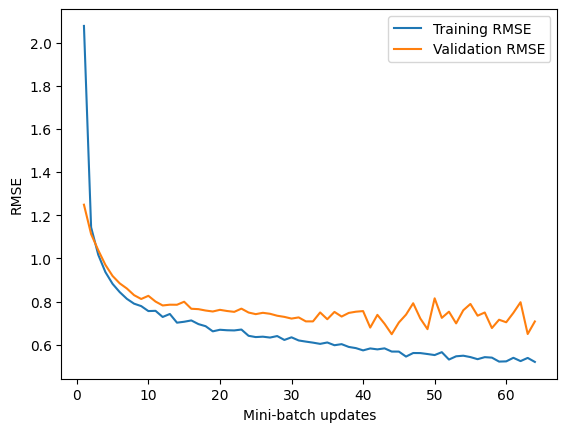

In [132]:
plt.plot(range(1, len(train_rmse_list) + 1), train_rmse_list, label='Training RMSE')
plt.plot(range(1, len(valid_rmse_list) + 1), valid_rmse_list, label='Validation RMSE')
plt.xlabel('Mini-batch updates')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [133]:
best_model = LSTM().to(device)
best_model.load_state_dict(torch.load(f"./model_weights/{config['model_name']}.ckpt"))
best_model.eval()
check_test_outputs = []
check_test_targets = []
with torch.no_grad():
  for Xs_test, Ys_test in test_loader:
      Xs_test, Ys_test = Xs_test.to(device), Ys_test.to(device)
      test_outputs = model(Xs_test)
      check_test_outputs.append(test_outputs.detach())
      check_test_targets.append(Ys_test.detach())

test_rmse, ori_outputs, ori_targets = calculate_rmse_check(check_test_outputs, check_test_targets)
# output = model(torch.tensor(testX).to(device))
# test_rmse = calculate_rmse(output, testY)
print(f"Model Test RMSE: {test_rmse}")

Model Test RMSE: 2.631613720463936


In [134]:
len(check_test_outputs)

365

In [135]:
#因為一次預測四周，所以除了第一次的四周我全要以外， 之後都只要最後一週192/4+4 =52 這是一次預測一個月的範例
real_preds = ori_outputs[:config['target_window_size']] + ori_outputs[config['target_window_size']::config['target_window_size']]
real_targets = ori_targets[:config['target_window_size']] +  ori_targets[config['target_window_size']::config['target_window_size']]

# 結果圖

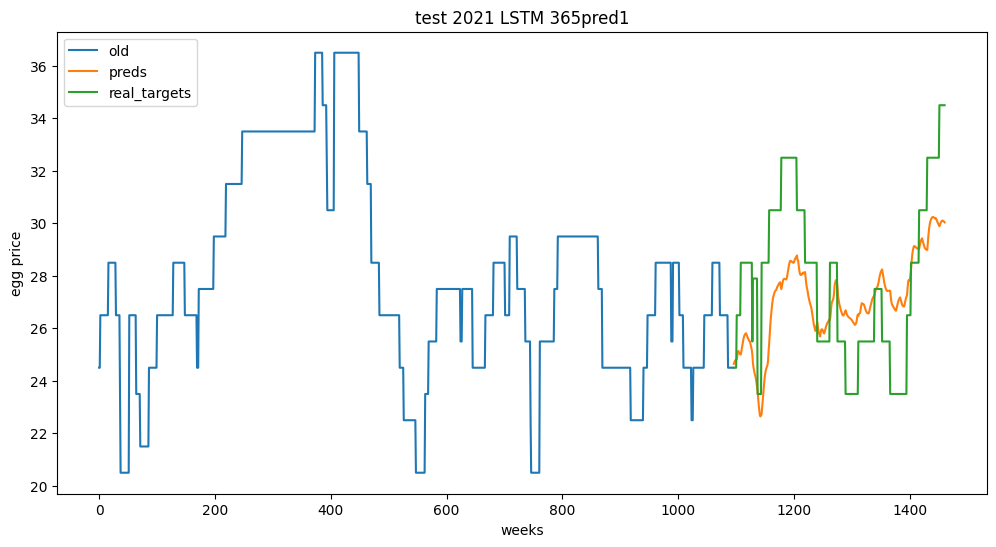

In [136]:
old = all_df.iloc[:, 0][:-(config['time_range'])].to_numpy()
# 對應的 x 範圍
cut_yr = (2022-config['test_year'])*52
old_yr = 7*(209-cut_yr)-3
x_range1 = np.arange(0, old_yr)
x_range2 = np.arange(old_yr, old_yr+config['time_range'])
x_range3 = np.arange(old_yr, old_yr+config['time_range'])

plt.figure(figsize=(12, 6))
plt.plot(x_range1, old, label='old')
plt.plot(x_range2, real_preds, label='preds')
plt.plot(x_range3, real_targets, label='real_targets')
plt.title(f"test {config['test_year']} LSTM 365pred1")
plt.xlabel('weeks')
plt.ylabel('egg price')
plt.legend()
plt.show()